# What Code Reviewers Talk About - A Machine Learning Experiment

A code review is a form of code inspection where a developer assesses code for style, defects, and other standards prior to integration into a code base. As part of the code review process on GitHub, developers may leave comments on portions of the unified diff of a GitHub pull request. These comments are extremely valuable in factilitating technical discussion amongst developers, and in allowing developers to get feedback on their code submissions. In an effort to better understand code reivewing habbits, we’re going to create an SVM classifier to classify over 30 000 GitHub review comments based on the main topic addressed by each comment (e.g. naming, readability, etc.).

![review](https://zir0-93.github.io/images/i-was-told-there-would-be-a-review.jpg)

# Review Comment Classifications

The list of categories we're going to incorporate into our classifier are summarized in the table below. This list was developed based on a manual survey of 
approximately 2000 GitHub review comments I performed on randomly selected, but highly forked Java repositories on GitHub. The selected 
categories reflect the most frequently occurring topics encountered in the surveyed review comments. Majority of the categories 
are related to code level concepts (e.g. variable naming, exception handling); however, certain review comments 
that did not naturally fall into any existing categories and were unrelated to the overall goal of code reviewing were placed in
the "other" category. In situations where a review comment discussed more than one subject, I gave it a classification according 
to the topic it spent the most words discussing.

| Category| Label | Further Explanation|  &nbsp; &nbsp; &nbsp;Sample Comment &nbsp; &nbsp; &nbsp;    |    
|-------------------|-------|--------------|-------------------------------------------------------|
| Readability                     | 1     | Comments related to readability, style, general project conventions.                                | "Please split this statement into two separate ones" |
| Naming                          | 2     |                                                                                                     | "I think foo would be a more appropriate name" |
| Documentation                   | 3     | Comments related to licenses, package info, module documentation, commenting.                       |"Please add a comment here explaining this logic" |
| Error/Resource Handling         | 4     | Comments related to exception/resource handling, program failure,  termination analysis, resource . |"Forgot to catch a possible exception here" |
| Control Structures/Program Flow | 5     | Comments related to usage of loops, if-statements, placement of individual lines of code.           |"This if-statement should be moved after the while loop" |
| Visibility/ Access              | 6     | Comments related to access level for classes, fields, methods and local variables.                  |"Make this final" |
| Efficiency / Optimization       | 7     |                                                                                                     |"Many uneccessary calls to foo() here" |
| Code Organization/ Refactoring  | 8     | Comments related to extracting code from methods and classes, moving large chunks of code around.   |"Please extract this logic into a separate method" |
| Concurrency                     | 9    | Comments related to threads, synchronization, parallelism.                                          |"This class does not look thread safe" |
| High Level Method Semantics & Design                           | 10    | Comments relating to method design and semantics.                                                           |"This method should return a String" |
| High Level Class Semantics & Design                           | 11    | Comments relating to class design and semantics.                                                           |"This should extend Foo" |
| Testing                           | 12    |                                                           |"is there a test for this?" |
| Other                           | 13    | Comments not relating to categories 1-12.                                                           |"Looks good", "done", "thanks" |

# SVM Classifier Implementation

Now we'll discuss our SVM text classifier implementation. This experiment represents a typical supervised learning classification exercise.
We'll start by first loading our training data from a local directory which consists of two files representing 2000 manually labelled comment-classification pairs. The [first file](https://raw.githubusercontent.com/Zir0-93/zir0-93.github.io/master/_posts/review_comments%20(1).txt) contains a review comment on each
line, while the [second file](https://raw.githubusercontent.com/Zir0-93/zir0-93.github.io/master/_posts/review_comments_labels%20(1).txt)  contains manually determined classifications for each corresponding review comment on each line.


In [1]:
with open('data/review_comments.txt') as f:
    review_comments = f.readlines()
    
with open('data/review_comments_labels.txt') as g:
    classifications = g.readlines()

Next, we are going to preprocess the raw data in multiple steps to prepare it for use by our SVM classifier. First, we remove all formatting characters from each comment that are associated with the Markdown syntax. Markdown is a lightweight
 markup language with plain text formatting syntax. It is designed to be easily converted to HTML and many other formats
 using a tool by the same name, and more importantly, can be used to write GitHub code review comments. This step is important because the additional formatting related characters introduced by the 
 Markdown standard will negatively impact our classifier's ability to recognize identical words.

In [2]:
import re 

def formatComment(comment):
        comment = re.sub("\*|\[|\]|#|\!|,|\.|\"|;|\?|\(|\)|`.*?`", "", comment)
        comment = re.sub("\.|\(|\)|<|>", " ", comment)
        comment = ' '.join(comment.split())
        return comment
        

def formatComments(comments):
    for index, comment in enumerate(comments):
        comments[index] = formatComment(comment)  

formatComments(review_comments)

**A note on using stopwords and stemmers.** My experimental results showed that using off the shelf stopword lists and stemmers to preprocess the data decreased the accuracy of the final classifier. This is why I have not used any of these techniques in this experiment.

The next step of our preprocessing stage is to convert the comment reviews into numerical feature vectors. This is required to
make our review comments amenable for machine learning algorithms. To do this, we will use the bag of words method, which 
represents a sentence using a feature vector developed based on the number of occurrences of each
term, known as *term frequency*. Note that, in this view, the comment `please rename this variable`, is identical
to the comment `rename this variable please`. We use the Scikit-learn Python library to create feature vectors for our 
review comments using the `CountVectorizer` module.

In [3]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
comments_train_counts = count_vect.fit_transform(review_comments)
comments_train_counts.shape

(2000, 4295)

We wil also experiment with incorporating the inverse document frequency statistic, a common technique used in text classification experiments. To understand how the technique works, consider a commonly occurring term like "the". A simple bag of words model based only on term frequency would tend to incorrectly emphasize review comments which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms like "variable" and "naming". This is problematic as the term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "variable" and "naming". Hence the inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

**Putting it all together, the weight the td-idf statistic assigns to a given term is:**

1. Highest when the term occurs many times within a small number of review comments
2. Lower when the term occurs fewer times in a review comment, or occurs in many review comments
3. Lowest when the term occurs in virtually all review comments.

At this point, we can view each review comment as a vector with one component
corresponding to each term in the dictionary, together with a weight for each
component that is given by the tf-idf statistic. For dictionary terms that do not occur in
a document, this weight is zero. This vector form will prove to be crucial to
the scoring and ranking capabilities of our SVM classifier.

In [4]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
comments_train_tfidf = tfidf_transformer.fit_transform(comments_train_counts)
comments_train_tfidf.shape

/opt/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(2000, 4295)

Now that the classifier itself is almost ready, an important consideration now is the amount of training data to use for testing the classifier. After ensuring that atleast 100 review comments for each classification are present in our labeled data set, I experimented with different numbers of review comments
to see what gave the best results. 2000 review comments seemed to give a good enough accuracy for our purposes. We will therefore dedicate 80% of our 2000 GitHub review comments data to the training set, which we will use to train our SVM classifier. The remaining 20% of the data will be dedicated to the test set, which we will use to test the performance of the developed classifier.

In [5]:
from sklearn.model_selection import train_test_split

comment_train, comment_test, classification_train, classification_test = train_test_split(review_comments, classifications, test_size=0.2)

Lastly, we can complete our classifier by combining the components developed so far with the scikit SVM classifier using the scikit `Pipeline` module. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. We also use the scikit `SGDClassifier` module to train our SVM model using Stochastic Gradient Descent (SGD). SGD is an iterative based optimization technique. In this case, the technique modifies the SVM parameters on each training iteration to find a local optimum that produces the best results. We set the number of iterations for our estimator at 1000. As demonstrated below, our developed classifier scored an accuracy of 82% on the test data set.

In [6]:
# Training Support Vector Machines - SVM and calculating its performance
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)
print(classification_report(classification_test, predicted_svm))

/opt/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


             precision    recall  f1-score   support

         1
       0.79      0.79      0.79        57
        10
       0.92      0.89      0.91        27
        11
       0.93      0.57      0.70        23
        12
       0.67      0.83      0.74        12
        13
       0.74      0.92      0.82       103
         2
       0.75      0.95      0.84        19
         3
       0.91      0.80      0.85        40
         4
       0.75      0.75      0.75        24
         5
       0.91      0.79      0.85        39
         6
       0.93      0.93      0.93        14
         7
       1.00      0.57      0.73         7
         8
       0.92      0.48      0.63        25
         9
       0.58      0.70      0.64        10

avg / total       0.82      0.81      0.80       400



An f1-score of 82% did not seem reliable enough for the purpose of classifying over 30 000 GitHub review comments. Moreover, I realized that the incorporation of the tf-idf statistic, while useful in other text classification activities, was not suitable for the classification of review comments. The reason for this can be traced to the treatment of uncommon words in this technique. In a regular document, an uncommon word, like "abject" for example, would be valuable in classifying that document. Review comments also contain uncommon terms; however, these terms mostly reference source code entities which we would not want to our classifier to place a major importance on. If our labeled data set for example consisted of a review comment that read, "The Foo class has some formatting issues.", we would manually assign the `Readability` classification to this comment. The problem is because `Foo` is an uncommon term, our tf-idf based SVM classifier would highly correlate this term with the `Readability` category, which is undesirable. This is because any future review comments containing the term  `Foo` would be given the `Readability` classification with a very high probability, which is undesired for obvious reasons. A solution to this problem would be to replace any source code entities referenced in review comments by a static string, like `<SYMBOL>` for example; However, this would be difficult to detect accurately. Therefore, we will simply revert the use of the tf-idf statistic, which raises the accuracy of our classifier significantly to 94%

In [7]:
# Training Support Vector Machines - SVM and calculating its performance
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), 
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='elasticnet',alpha=1e-3, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(review_comments, classifications)
predicted_svm = text_clf_svm.predict(comment_test)
print(classification_report(classification_test, predicted_svm))

             precision    recall  f1-score   support

         1
       0.96      0.89      0.93        57
        10
       0.96      1.00      0.98        27
        11
       1.00      1.00      1.00        23
        12
       1.00      1.00      1.00        12
        13
       0.87      0.98      0.92       103
         2
       0.95      1.00      0.97        19
         3
       0.97      0.95      0.96        40
         4
       1.00      0.88      0.93        24
         5
       0.97      0.95      0.96        39
         6
       1.00      0.86      0.92        14
         7
       1.00      1.00      1.00         7
         8
       1.00      0.88      0.94        25
         9
       1.00      0.90      0.95        10

avg / total       0.95      0.95      0.95       400



# Classifying GitHub Review Comments
We will now leverage the classifier developed in the previous section to classify over 30000 GitHub review comments from the top 100
most forked Java repositories on GitHub. GitHub exposes a REST API that allows developers to interact with the platform, which we will use to mine our Review Comments. In general,
an API provides an interface between two systems to interact with each other programmatically. Representational State Transfer (REST) 
is an architectural style that defines a set of constraints and properties based on HTTP. APIs that conform to the REST architectural 
style, or RESTful web services, provide interoperability between computer systems on the Internet. We first consume the GitHub REST API to
load repository data for the 100 most forked java repositories on GitHub.

In [8]:
import urllib.request
import json

# URL to consume GitHub REST API to retrieve the top 50 most forked repositories on GitHub
url = 'https://api.github.com/search/repositories?q=language:java&sort=forks&order=desc&per_page=100&page=1'
# Execute the HTTP GET request
resp_text = urllib.request.urlopen(urllib.request.Request(url)).read().decode('UTF-8')
# load the JSON response in a python object
repos_json_obj = json.loads(resp_text)

Next, we're going to use the GitHub REST API again to collect a list of all the review comments from each repository. Note, the code below will require you to add your own GitHub OAuth token if you wish to execute it yourself.

In [9]:
###########################################
github_access_token = 'b9087d84cce932a6daa94edcbeeae83c0205ffdb'
###########################################

review_comments = []
# loop through our list of repositories..
for repo in repos_json_obj['items']:
    # i is the current page number
    for j in range(1, 10):
        # URL to consume GitHub REST API to retrieve 100 review comments
        url = 'https://api.github.com/repos/' + repo['owner']['login'] \
        + '/' + repo['name'] + '/pulls/comments?direction=desc&per_page=100&page=' + str(j) \
        + '&access_token=' + github_access_token
        # Execute the HTTP GET request and store response in object
        json_obj = json.loads(urllib
                              .request
                              .urlopen(urllib.request.Request(url))
                              .read()
                              .decode('UTF-8'))
        # Store all review comments from the response
        review_comments.extend(json_obj)

print ('Collected', str(len(review_comments)), 'review comments.')

Collected 31617 review comments.


Now we will categorize each review comment using our SVM classifier, and generate a donut chart demonstrating our results.


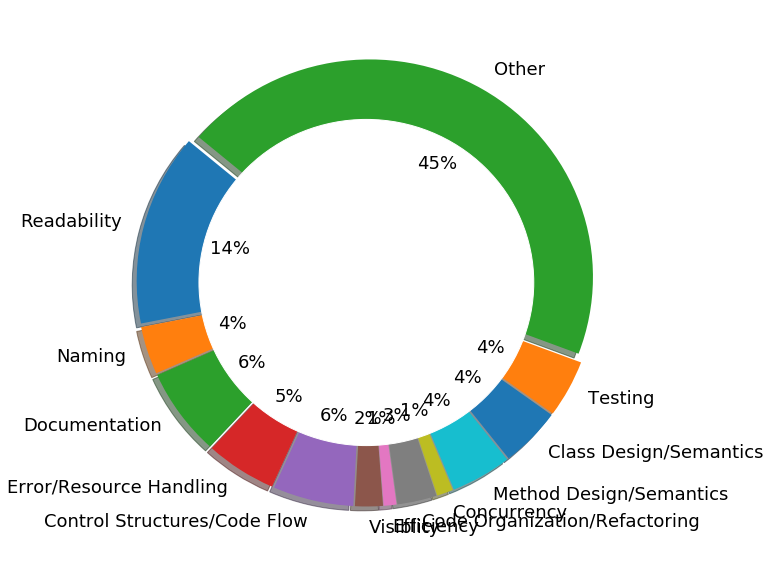

In [11]:
import matplotlib.pyplot as plt
import matplotlib
from palettable.tableau import Tableau_10

matplotlib.rcParams.update({'font.size': 18})

# Data to plot
labels = ['Readability', 'Naming', 'Documentation', 'Error/Resource Handling', 
'Control Structures/Code Flow', 'Visiblity', 'Efficiency', 'Code Organization/Refactoring',
'Concurrency', 'Method Design/Semantics', 'Class Design/Semantics', 'Testing', 'Other']


sizes = [0] * 13
explode = [0.03] * 13

# loop through review comments and score
for review_comment in review_comments:
    label = int(text_clf_svm.predict([formatComment(review_comment['body'])])[0])
    sizes[label - 1] += 1

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.75, color='white')

# Plot
plt.pie(sizes, labels=labels, colors=Tableau_10.hex_colors,
        autopct='%1.0f%%', explode=explode, shadow=True, startangle=140) 
fig = plt.gcf().set_size_inches(10,10) 
plt.gca().add_artist(my_circle)
plt.show()